# Clustering Yelp Restaurants

**Part 2: To be completed INDIVIDUALLY and due on October 21 at 7pm.**

In this assignment, we will continue to work with the [Yelp dataset](https://drive.google.com/open?id=0B4bdB5WPHGsqcmJMNmxzQmQ3aTQ) that we used in Homework 2-1.

We will continue to try to find culinary districts in Las Vegas. 

(As a reminder from last time, these are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness.)

However, in this analysis we will not use the Yelp-supplied "categories" to cluster for similarity as we did in Part 1.

Instead we will cluster the reviews themselves, extracting categories in an unsupervised fashion.  

Specifically, you are to use Latent Semantic Analysis (LSA) on the Yelp reviews to cluster restaurants based off on their reviews.  As a reminder, LSA consists of using PCA applied to the document-term matrix.

LSA was covered in lecture, and there is another tutorial [here.](http://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf
)

**(20 pts)**

In [237]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [238]:
# read in all restuarants in las vagas
import json
business = {}
with open('yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json') as f:
    for line in f:
        tmp = json.loads(line)
        if tmp['city']=='Las Vegas':
            if 'Restaurants' in tmp['categories']:
                business[tmp['business_id']] = {'latitude':tmp['latitude'], 'longitude':tmp['longitude']}

In [239]:
# read in all reviews of restaurants in las vegas
with open('yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json') as f:
    for line in f:
        tmp = json.loads(line)
        if tmp['business_id'] in business:
            if 'review' in tmp['business_id']:
                business[tmp['business_id']]['review'] = ''.join(str(tmp['text']))
            else:
                business[tmp['business_id']]['review'] = tmp['text']

In [377]:
# create separate lists of business_id, latitude, longitude and review, with the same ordering
business_id = []
latitude = []
longitude = []
review = []
for key,val in business.items():
    business_id.append(key)
    latitude.append(val.get('latitude'))
    longitude.append(val.get('longitude'))
    review.append(str(val.get('review')))
latitude = np.array(latitude)
longitude = np.array(longitude)

In [378]:
# strip digits from all reviews
from string import digits
remove_digits = str.maketrans('', '', digits)
review = [rev.translate(remove_digits) for rev in review]

In [379]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

# stemming
from nltk.tokenize import sent_tokenize
review = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
         for sent in sent_tokenize(rev)
        for word in word_tokenize(sent))
        for rev in review]

In [381]:
from sklearn.feature_extraction.text import TfidfVectorizer

# convert strings to numeric matrix
# choose max_df and min_df to filter out the most informative words
vectorizer = TfidfVectorizer(max_df=0.18, min_df=0.009, stop_words='english', sublinear_tf=True,use_idf=True)
X_cat = vectorizer.fit_transform(review)
terms = vectorizer.get_feature_names()

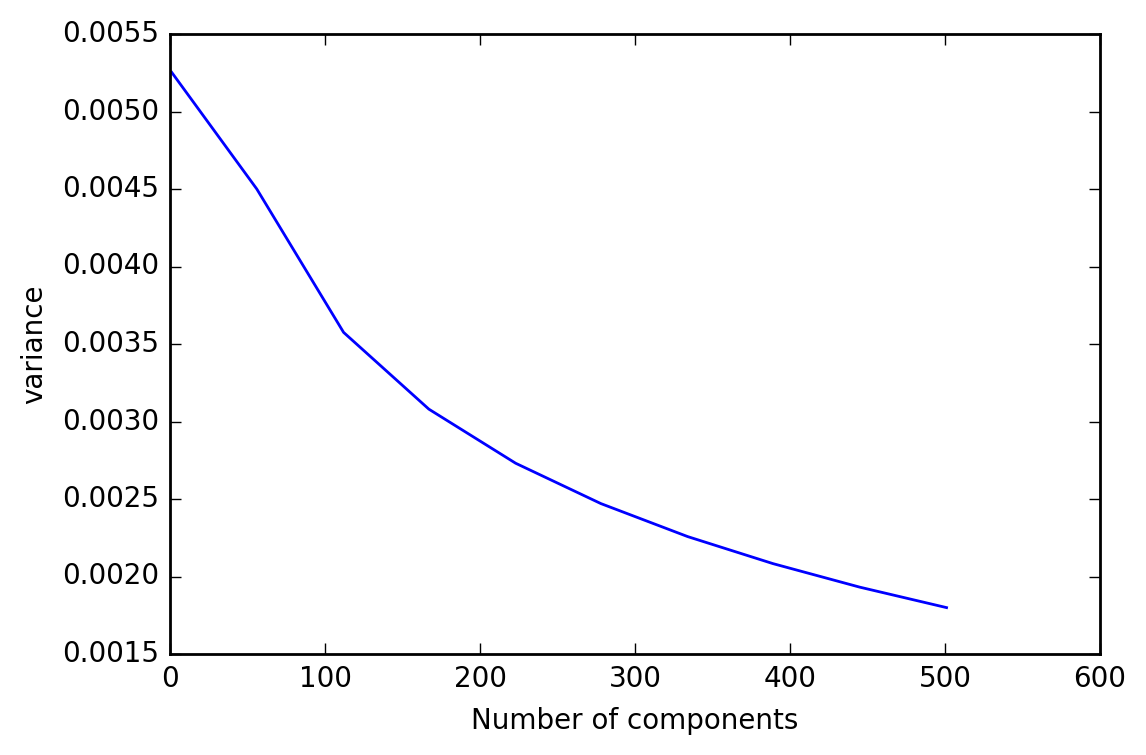

In [735]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# apply LSA on reviews
variance = np.zeros(10)
ii = 0
for kk in np.linspace(1,501, 10, dtype='int16'):
    lsa = TruncatedSVD(kk, algorithm = 'arpack')
    X_lsa = lsa.fit(X_cat)
    variance[ii] = X_lsa.explained_variance_ratio_.mean()
    ii += 1
    
plt.plot(np.linspace(1,501, 10, dtype='int16'),variance)
plt.xlabel('Number of components')
dummy = plt.ylabel('variance')
plt.show()

In [737]:
# select k=100 to apply to SVD
lsa = TruncatedSVD(100, algorithm = 'arpack')
X_lsa = lsa.fit_transform(X_cat)
# normalize category columns and rescale to give location a larger weight
X_lsa = Normalizer(copy=False).fit_transform(X_lsa)
variance = lsa.explained_variance_ratio_.mean()
print ('average variance for each component reaches: {}'.format(variance))

average variance for each component reaches: 0.003718420614417158


Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot and label each cluster. 

Note that to label each cluster, you will need to think about how to extract labels from the LSA results.
**(25 pts)**

In [738]:
# normalize and rescale location columns
location = 1000 * Normalizer(copy=False).fit_transform(np.column_stack((latitude, longitude)))
X_train = np.concatenate((X_lsa, location), axis=1)

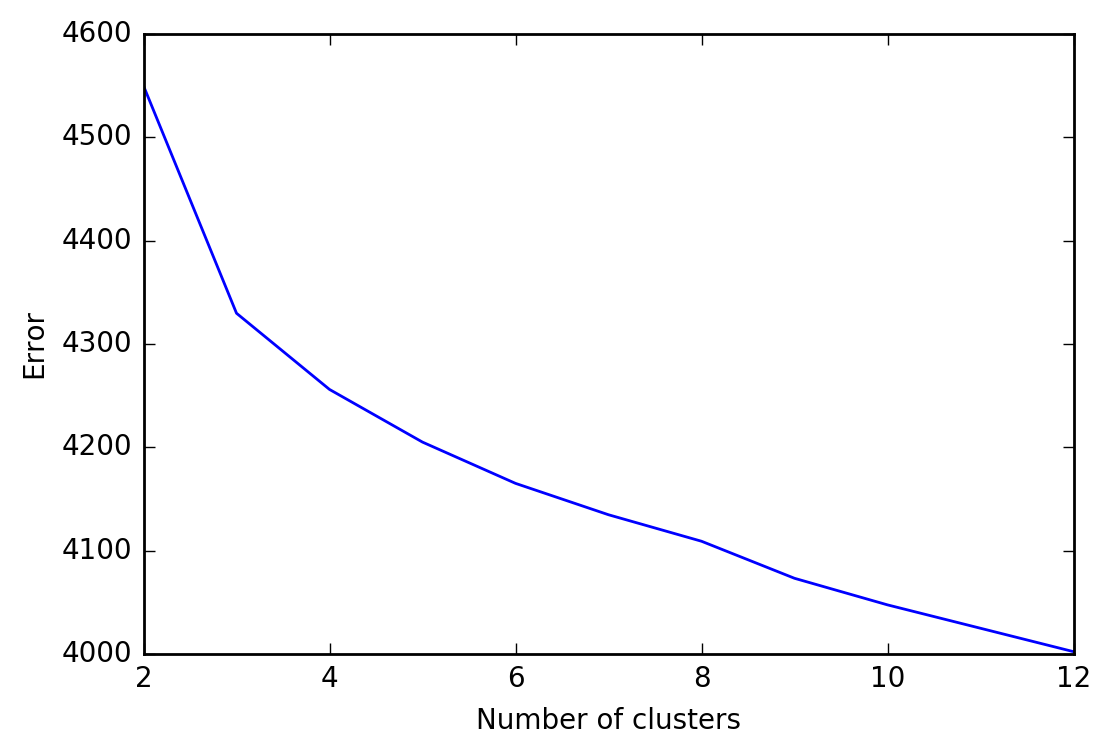

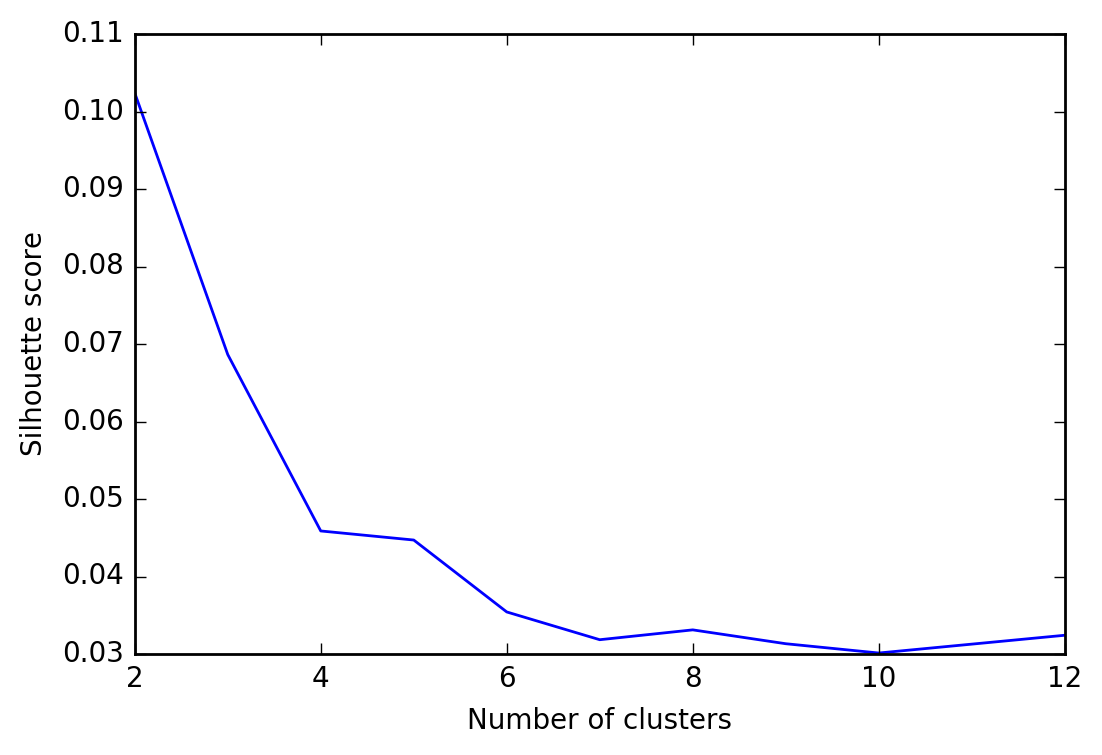

In [739]:
# apply kmeans on training data
from sklearn.cluster import KMeans
from sklearn import metrics
error = np.zeros(10)
sc = np.zeros(10)
ii = 0
for k in np.linspace(2, 12, 10, dtype='int8'):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=4, random_state=0)
    labels = kmeans.fit_predict(X_train)
    error[ii] = kmeans.inertia_
    sc[ii] = metrics.silhouette_score(X_train,labels)
    ii += 1
    
plt.plot(np.linspace(2, 12, 10, dtype='int8'), error)
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Error')
plt.show()

plt.plot(np.linspace(2, 12, 10, dtype='int8'), sc)
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Silhouette score')
plt.show()

In [740]:
# select k=5 to cluster
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=100, n_init=10, random_state=0)
km_pred = kmeans.fit_predict(X_train)
kmeans.inertia_

4205.0571153097899

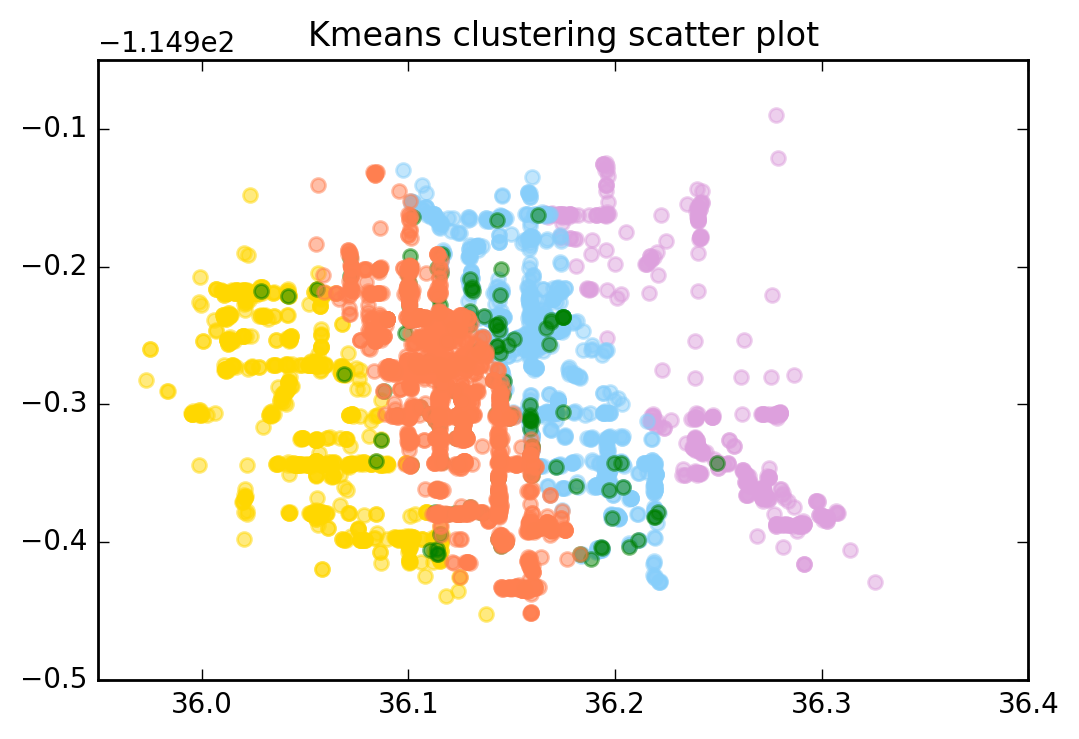

In [741]:
colors = ['plum', 'gold', 'lightskyblue', 'green', 'coral'] * 3
for l in np.unique(km_pred):
    plt.scatter(latitude[km_pred==l], longitude[km_pred==l], s=25, color=colors[l], alpha=0.5)
plt.title('Kmeans clustering scatter plot')
plt.show()

In [742]:
km_centers_lsa = kmeans.cluster_centers_
ori_centers = lsa.inverse_transform(km_centers_lsa[:,:100])
order_centroids = ori_centers.argsort()[:, ::-1]

In [743]:
# print out the top 50 words with largest weight in each cluster
for i in range(5):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i,:50]:
            print(' %s' % terms[ind], end='')
        print('\n')

Cluster 0: alway pizza love tri locat chicken fri friend come did ve staff best got custom work realli make wait taco sandwich chees look cook fast fresh close restaur went came sauc say tast ask want nice price disappoint way drive clean new better minut star breakfast meal use busi delici

Cluster 1: come love alway friend locat pizza realli tri eat got restaur make nice ve price chicken custom close sandwich delici staff fri did work say want know fresh tast busi wait peopl came star new went better clean meal look sauc lunch right fast drink pretti bad definit minut ask

Cluster 2: love tri alway pizza friend price did locat eat realli come got staff nice restaur wait best chicken ask vega taco custom fri star want know make look came sandwich tast delici littl peopl bad went fresh ve clean minut fast drink better amaz way work breakfast definit burger pretti

Cluster 3: close sad open restaur busi locat door love sign new know vega today went year ago review said best month miss w

From the output, we can probably give each cluster the following tags:

cluster 0: 'fast food', 'fresh', 'good to come with frieds on weekends', 'breakfast'...

cluster 1: 'lovely place', 'delicious and fresh', 'lunch', 'drinks'...

cluster 2: 'fast food', 'taco', 'breakfast','tasty', 'clean and fresh'...

cluster 3: 'lunch', 'nightlife', 'buffet'...

cluster 4: 'delicious', '', 'nightlife', 'hang out with friends', 'expensive'...

In [744]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(X_train)
agg_predict = agg.labels_

cluster 0
 thai lamb steam ambianc mediocr prime cocktail spring salmon pho reserv korean curri noodl hostess entre ring sushi meet nasti guest wine beauti broth japanes tuna date simpli taken vegetarian spend convers speak glass bun seafood yum immedi woman asian bartend accommod discount club appet eye dont knew bottl view

cluster 1
 carn asada pepperoni tortilla crust forward yeah caus crisp sell convers regist kick gotten young weird matter ridicul similar frozen appar pie plain bomb goe break airport taken heat anymor earli mac woman tonight generous sick addit discount cover figur somewher neighborhood chose origin improv soggi certain mistak general step

cluster 2
 prime immedi hostess date simpli american taken chose cocktail la reserv certain ridicul steam pricey japanes mediocr weekend doubl diner question club eye view middl similar juici tradit weird kick forev avoid bottl orang accommod buffet ambianc bother dont ring lamb guest station rush yeah pancak goe overpr mom ro

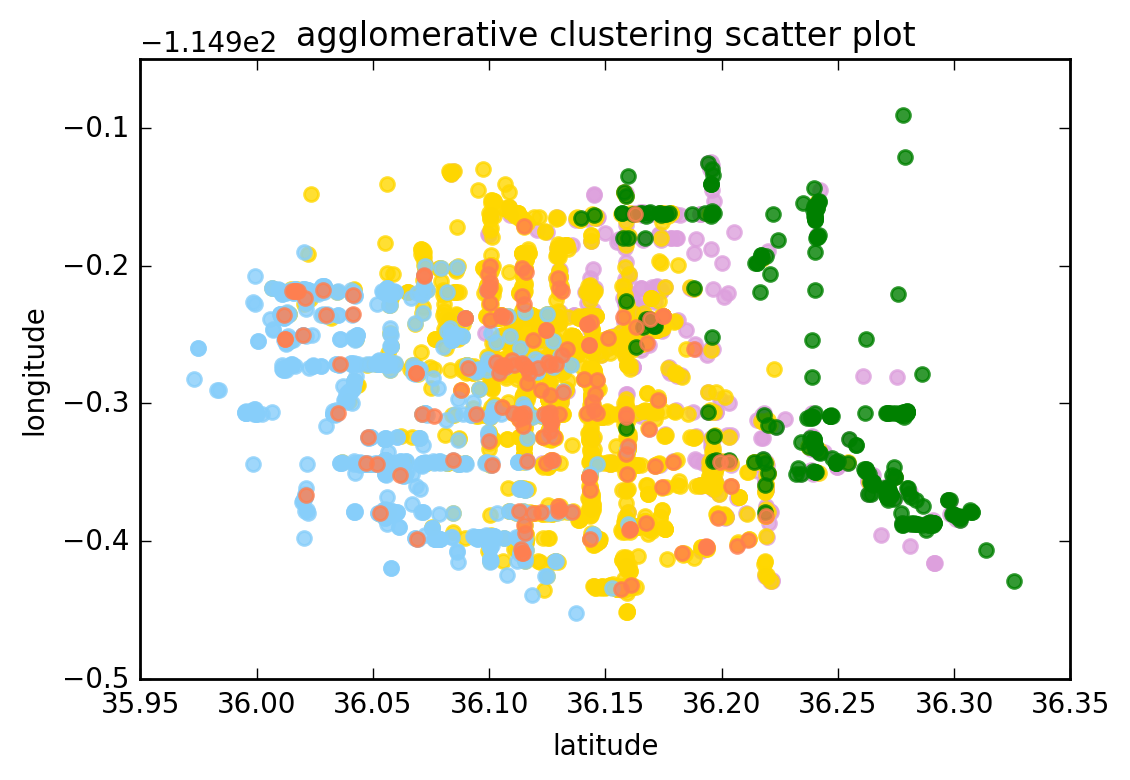

In [780]:
import warnings
warnings.filterwarnings('ignore')

for l in np.unique(km_pred):
    print ('cluster {}'.format(l))
    plt.scatter(latitude[agg_predict==l], longitude[agg_predict==l], s=25, color=colors[l], alpha=0.8)
    center_agg = lsa.inverse_transform(np.mean(X_train[agg_predict==l][:,:100], axis=0)).argsort()[::-1].reshape(-1, 1)
    for ind in center_agg[ :50]:
        print(' %s' % terms[ind], end='')
    print('\n')
plt.title('agglomerative clustering scatter plot')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

From the output, we can probably assign labels to each cluster:

cluster 0: 'asian', 'seafood', 'alcohol', 'vegetarian'...

cluster 1: 'mexico', 'italian', 'close to airport', 'froze food'...

cluster 2: 'good for dates', 'american', 'pricey','japanese', 'dinner'...

cluster 3: 'cheap', 'america', 'salmon and tuna', 'pepperoni and sausage'...

cluster 4: 'bad service', 'wine and cocktail', 'long wait', 'pricey', 'yummi'...

In [776]:
from sklearn import mixture

gmm = mixture.GMM(n_components=5, covariance_type='tied')
gmm.fit(X_train)
gmm_pred = gmm.predict(X_train)

cluster 0
 cold breakfast miss thai salsa bartend mexican dri curri dog french pizza yummi bread deliveri steak hit lamb street add stuff diner healthi wo pancak pictur idea problem dessert game bland dollar hotel salt sell italian nacho correct onion middl portion dip kinda rib suck pasta complet morn employe extra

cluster 1
 tortilla roast add turkey chili bean crust white ingredi typic forev vegetarian avocado valu dip kick authent tradit appreci corn melt understand request split dollar share doubl consid caus prepar veget prefer standard soft la bake healthi prompt gotten pricey butter plenti carn combo question accommod pepperoni soggi pepper cover

cluster 2
 chines dish subway noodl beauti chef slow deliv bun turkey steam server mediocr pho italian cours fun ambianc mushroom welcom bake curri butter spring reserv piec pepperoni sausag caesar hear soup pie prime generous garlic seafood express pasta sushi japanes waitress decor deliveri veget issu trip speak tuna eye asian

clu

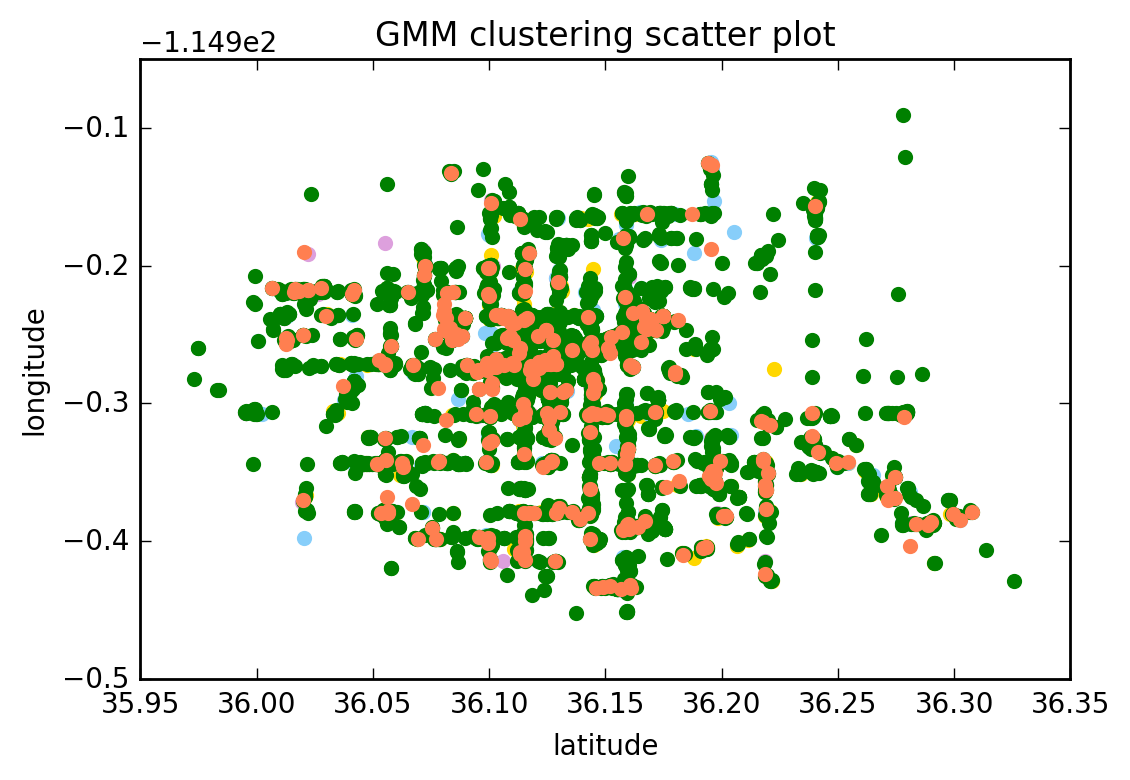

In [781]:
for l in np.unique(gmm_pred):
    print ('cluster {}'.format(l))
    plt.scatter(latitude[gmm_pred==l], longitude[gmm_pred==l], color=colors[l])
    center_gmm = lsa.inverse_transform(np.mean(X_train[gmm_pred==l][:,:100], axis=0)).argsort()[::-1].reshape(-1, 1)
    for ind in center_gmm[ :50]:
        print(' %s' % terms[ind], end='')
    print('\n')
plt.title('GMM clustering scatter plot')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

From the output, we can probably assign labels to each cluster

cluster 0: 'breakfast', 'cold food', 'mexican', 'frech', 'yummi', 'support delivery', 'italian'...

cluster 1: 'mexico', 'italian', 'close to airport', 'froze food'...

cluster 2: 'good for dates', 'american', 'pricey','japanese', 'dinner'...

cluster 3: 'cheap', 'america', 'salmon and tuna', 'pepperoni and sausage'...

cluster 4: 'bad service', 'wine and cocktail', 'long wait', 'pricey', 'yummi'...

Compare your clusters with the results you obtained in Part 1. Use cluster comparison metrics, and also comment on which clustering appears (from your inspection of the clusters) to be more informative, and why. **(15 pts)**

In [783]:
# Part 1: cluster by categories
from sklearn.feature_extraction.text import CountVectorizer

data = []
keys = ['categories', 'latitude', 'longitude']
with open('yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json') as f:
    for line in f:
        tmp = json.loads(line)
        if tmp['city'] == 'Las Vegas':
            if 'Restaurants' in tmp['categories']:
                tmp = [tmp[key] for key in keys]
                tmp[0] = ' '.join(map(str, tmp[0])) 
                data.append(tmp)
                
vectorizer = CountVectorizer(min_df=1, max_features=20, stop_words=['restaurants','new','food'])
category = vectorizer.fit_transform(data[i][0] for i in range(len(data))).toarray()
tags = vectorizer.get_feature_names()

In [784]:
coor = np.column_stack(([tmp[1] for tmp in data],[tmp[2] for tmp in data]))
coor_nml = 20 * Normalizer().fit_transform(coor)
cat_nml = Normalizer().fit_transform(category)
X = np.concatenate((cat_nml, coor_nml), axis=1)

Kmeans error: 2207.1093901291583.
Cluster 0: pizza italian sandwiches chicken burgers
Cluster 1: american traditional bars nightlife breakfast
Cluster 2: fast sandwiches bars burgers japanese
Cluster 3: mexican fast american seafood bars
Cluster 4: chinese fast seafood japanese bars


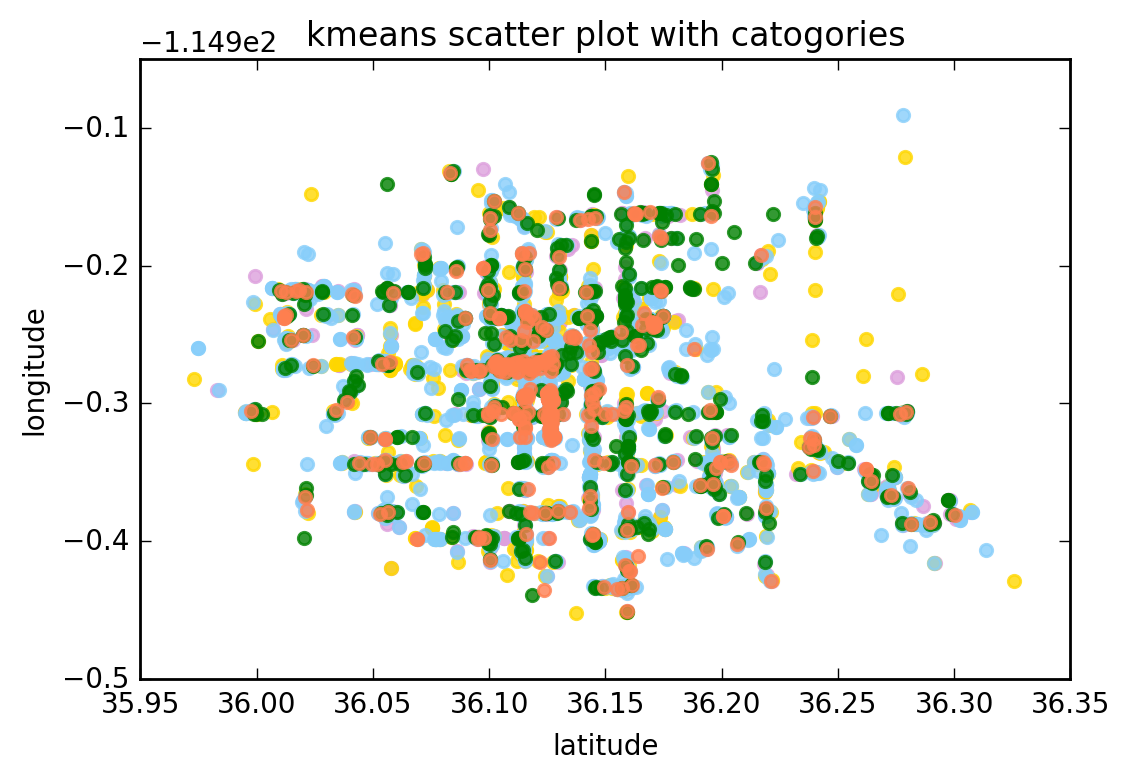

In [787]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmean_predict1 = kmeans.fit_predict(X)

centroids1 = kmeans.cluster_centers_
labels1 = kmeans.labels_
error1 = kmeans.inertia_
print("Kmeans error: {}.".format(error1))
cat_centroids1 = centroids1[:,:-2].argsort()[:, ::-1]
for i in range(5):
        print("Cluster %d:" % i, end='')
        for ind in cat_centroids1[i,:5]:
            print(' %s' % tags[ind], end='')
        print()
for l in np.unique(labels1):
    plt.scatter(coor[labels1==l, 0], coor[labels1==l, 1], color=colors[l], alpha=0.8)

plt.title('kmeans scatter plot with catogories')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()        

In [788]:
sc_kmeans_1 = metrics.silhouette_score(X, labels1)
sc_kmeans_2 = metrics.silhouette_score(X_train,km_pred)

print ('silhouette score of kmeans for part1 and part2:')
print (sc_kmeans_1)
print (sc_kmeans_2)

silhouette score of kmeans for part1 and part2:
0.32721319403
0.0447048910151


cluster 0
 abl airport anywher alway anymor

cluster 1
 alreadi answer add ambianc airport

cluster 2
 ambianc anoth add alway airport

cluster 3
 anoth alway answer ago add

cluster 4
 accommod american amaz abl anyth



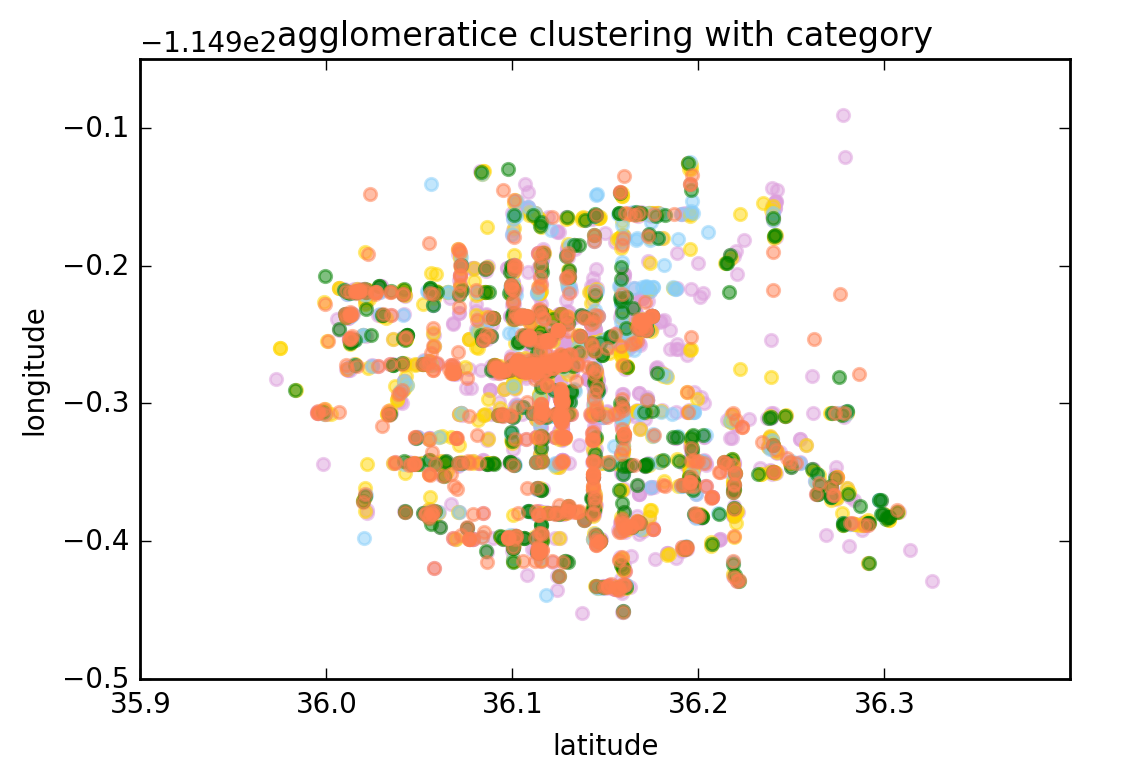

In [797]:
agg1 = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(X)
agg_predict1 = agg1.labels_

# scatter plot agglomerative clustering in reduced dimension
for l in np.unique(agg_predict1):
    print ('cluster {}'.format(l))
    plt.scatter(coor[agg_predict1==l, 0], coor[agg_predict1==l, 1], color=colors[l], alpha=0.5)
    center_agg = np.mean(X[agg_predict1==l][:,:-2], axis=0).argsort()[::-1].reshape(-1, 1)
    for ind in center_agg[ :5]:
        print(' %s' % terms[ind], end='')
    print('\n')
plt.title('agglomeratice clustering with category')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

In [798]:
sc_agg_1 = metrics.silhouette_score(X, agg_predict1)
sc_agg_1 = metrics.silhouette_score(X_train, agg_predict)
print ('silhouette score of hierarchical clustering for part1 and part2:')
print (sc_kmeans_1)
print (sc_kmeans_2)

silhouette score of hierarchical clustering for part1 and part2:
0.32721319403
0.0447048910151


In [794]:
gmm1 = mixture.GMM(n_components=5, covariance_type='tied')
gmm1.fit(X)
gmm_predict1 = gmm1.predict(X)

cluster 0
 ambianc alreadi abl anymor ad

cluster 1
 abl anywher actual ad add

cluster 2
 accommod american abl anyth amaz

cluster 3
 anoth alway answer ago abl

cluster 4
 alreadi airport answer add alway



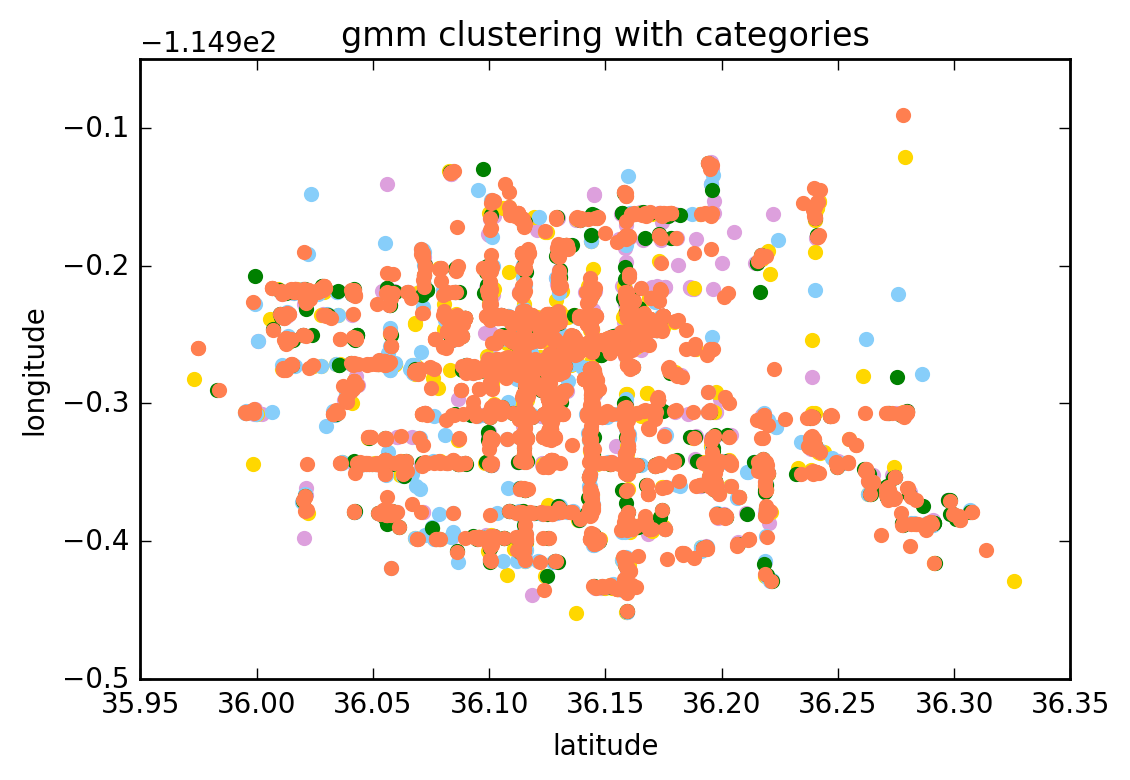

In [799]:
for l in np.unique(gmm_predict1):
    print ('cluster {}'.format(l))
    plt.scatter(coor[gmm_predict1==l, 0], coor[gmm_predict1==l, 1], color=colors[l])
    center_gmm = np.mean(X[gmm_predict1==l][:,:-2], axis=0).argsort()[::-1].reshape(-1, 1)
    for ind in center_gmm[ :5]:
        print(' %s' % terms[ind], end='')
    print('\n')
plt.title('gmm clustering with categories')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

In [800]:
sc_gmm_1 = metrics.silhouette_score(X,gmm_predict1)
sc_gmm_2 = metrics.silhouette_score(X_train,gmm_pred)
print ('silhouette score of GMM clustering for part1 and part2:')
print (sc_gmm_1)
print (sc_gmm_2)

silhouette score of GMM clustering for part1 and part2:
0.319628448151
0.0107459445037


From the silhouette scores computed above, all clustering methods using SVD in part 2 are lower than part 1. From the appearance, GMM tends to have overlapping clusters. 

From processing reviews, we can get more informative descriptions for each cluster. 

----------